#### 使用ICA（独立成分分析）算法检测并去除心电(ECG)伪迹

In [6]:
import mne
import numpy as np
from mne.datasets import sample

from mne.preprocessing import ICA
from mne.preprocessing import create_ecg_epochs

In [7]:
# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
# load and pick data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 40, n_jobs=2)  # 1Hz high pass is often helpful for fitting ICA

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 497 samples (3.310 sec) selected


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 183 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 363 out of 366 | elapsed:   15.1s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 366 out of 366 | elapsed:   15.2s finished


In [8]:
raw.plot();

#### Fit ICA

In [9]:
n_components = 25  # if float, select n_components by explained variance of PCA; 值的注意的是这里可以为小数，但表达了不同的含义，具体请查看具体api
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


In [10]:
# Avoid fitting ICA on crazy environmental artifacts that would dominate the variance and decomposition
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [4242, 4343]
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [5858, 5959]
Selection by number: 25 components
Fitting ICA took 3.2s.
<ICA  |  raw data decomposition, fit (fastica): 13635 samples, 25 components, channels used: "mag"; "grad">


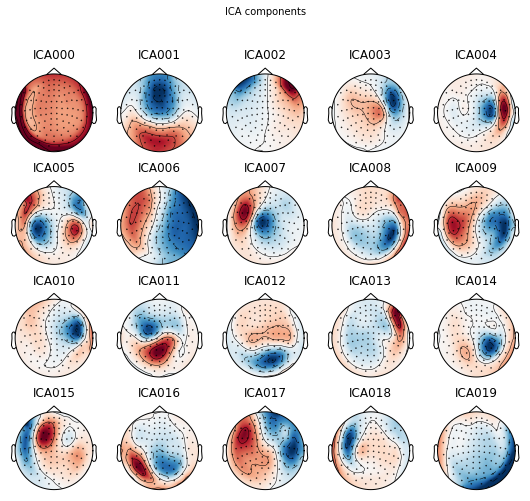

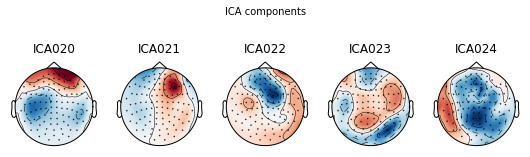

In [11]:
ica.plot_components();

#### Look at properties of single independent components.

    Using multitaper spectrum estimation with 7 DPSS windows


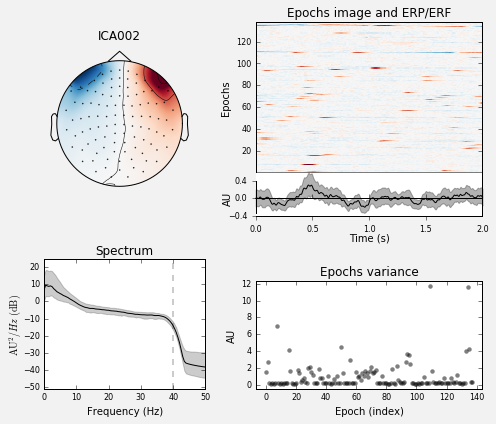

In [12]:
ica.plot_properties(raw,picks=2);

## Advanced artifact detection and remove

In [ ]:
ecg_average = create_ecg_epochs(raw,reject=dict(mag=5e-12,grad=4000e-13))